# Analysis of Best Water Solution

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


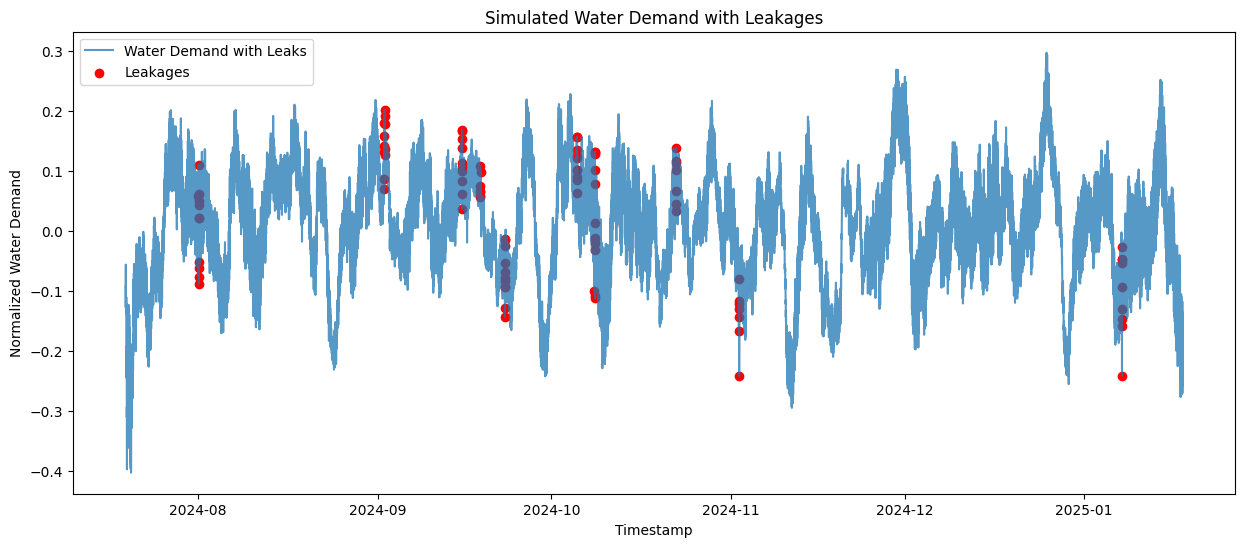

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import random
import datetime

# Function to generate water demand time series using ARIMA
def generate_water_demand(n_points=17620, seed=None):
    if seed is not None:
        np.random.seed(seed)
  # ARIMA parameters
    p, d, q  = 5, 2, 5
    model   = ARIMA(np.random.randn(n_points), order=(p, d, q))
    model_fit = model.fit()
    water_demand = model_fit.predict(start=0, end=n_points-1)
    return water_demand

# Function to inject leakage events into the time series
def inject_leakages(time_series, num_leaks, leak_duration_range=(4, 12), leak_increase_range=(0.5, 1), seed=None):
  if seed is not None:
    random.seed(seed)
  leakage_labels = np.zeros(len(time_series))
  n_points = len(time_series)

  for _ in range(num_leaks):
    leak_start = random.randint(0, n_points - leak_duration_range[1] - 1)
    leak_duration = random.randint(leak_duration_range[0], leak_duration_range[1])
    leak_increase = random.uniform(leak_increase_range[0], leak_increase_range[1])
    time_series[leak_start:leak_start + leak_duration] *= (1 + leak_increase)
    leakage_labels[leak_start:leak_start + leak_duration] = 1
  return time_series[100:], leakage_labels[100:]

# Generate the water demand time series with a fixed seed and number of leakages
seed   = 50
num_leaks = 10
water_demand = generate_water_demand(seed=seed)

# Inject leakage events with a fixed seed
water_demand_with_leaks, leakage_labels = inject_leakages(water_demand.copy(), num_leaks=num_leaks)

# Create a time index
start_date = datetime.datetime.now()
time_index = pd.date_range(start=start_date, periods=len(water_demand_with_leaks), freq='15T')

# Create the DataFrame
df = pd.DataFrame({
  'Timestamp': time_index,
  'WaterDemandWithLeaks': water_demand_with_leaks,
  'LeakageLabel': leakage_labels
})

# Plotting the generated data
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['WaterDemandWithLeaks'], label='Water Demand with Leaks', alpha=0.75)
plt.scatter(df[df['LeakageLabel'] == 1]['Timestamp'], df[df['LeakageLabel'] == 1]['WaterDemandWithLeaks'], color='red', label='Leakages')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Normalized Water Demand')
plt.title('Simulated Water Demand with Leakages')
plt.show()

# Save to Excel
df.to_csv('Data_water_demand_with_leaks_'+str(seed)+'_'+str(num_leaks)+'.txt', index=False)

# Define additional constraints
Including temperature & Hydrostatic pressure.
Note the code for both of these is increadibly basic, and not true to real life whatsoever, and are just here to provide additional features.

Hydrostatic presure will be by far the most wrong as it will almost certainly be a feature in both demand and losses


In [2]:
# Generate temperature, doing this as a categorical variable 0 is very cold 1 cold 2 medium 3 hot 4 very hot
random.seed = seed
temperature_list = random.randrange(0,4,17520)
df["CategoricalTemperature"] = temperature_list


In [3]:
# Generates hydrostatic pressure. Measured in Bars with an average between 1 and 6
bar_list = random.randrange(1,6,17520)
df["PressureInBars"] = bar_list



In [8]:
def categoriseTime(X):
  if X.hour < 6:
        return 0.85
  elif X.hour < 12:
        return 1.67
  elif X.hour < 18:
        return 2
  else:
        return 0.5

df["TimeCategorised"] = df["Timestamp"].apply(lambda x: categoriseTime(x))

# Define State Space & Actions

In [11]:
import gym
from gym import spaces

In [46]:
"""
Defenition to define the state space & action space in a class so it can be trained using PyTorch.
Primary area is the window avaliable to the model at each given time.

Will use openAI's gym to define the state space as it's easier & quicker than doing it by hand.
"""

class generateEnv(gym.Env):

  def __init__(self,data,rewardRange,window):
    self.data = data
    self.rewardRange = rewardRange
    self.window = window
    #Actions of the format either send a repair team. Integer to force the space to be discrete.
    self.actionSpace = spaces.Discrete(2)
    self.observationSpace = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5, window), dtype=np.float32
        )
    self.reset()
  #Calculates the reward involves the cost of repair and
  #a scaling cost based on how long a leak has been left
  def _calculateReward(self,action):
    costSendTeam = 30
    costLeakTax = 2

    if action == 1:
      reward = -costSendTeam

    else:
      #calculates how long since last leak & the current water demand
      # I.e if there is a leak and water demand is high I've added 1
      # to water demand to remove negative values this is spurius.
      # Also if the temperature is 3-4 the poor work crews take longer so it costs more
      # Timesed by the current time step
      leakDuration = self.Leak[self.currentStep]
      waterDemand = self.WaterDemand[self.currentStep] +1
      timeCost = self.TimeCategorised[self.currentStep]
      if self.Temperature[self.currentStep] >=3:
        return costLeakTax * leakDuration * waterDemand *2 * timeCost
      reward = -costLeakTax * leakDuration * waterDemand * timeCost
    return reward


  #Resets to initial state
  def reset(self):
    self.WaterDemand = self.data["WaterDemandWithLeaks"].values
    self.Leak = self.data["LeakageLabel"].values
    self.Temperature = self.data["CategoricalTemperature"].values
    self.HydrostaticPressure = self.data["PressureInBars"].values
    self.TimeCategorised = self.data["TimeCategorised"].values
    self.sendTeam = 0

    self.currentStep = random.randint(0,len(self.data.loc[:"LeakageLabel"])- self.window)

    return self._nextObservation()

  def _nextObservation(self):
    #generates the space from the last x days based on the window specified
    space =  np.array([
            self.WaterDemand[self.currentStep: self.currentStep + self.window],
            self.Leak[self.currentStep: self.currentStep + self.window],
            self.Temperature[self.currentStep: self.currentStep + self.window],
            self.HydrostaticPressure[self.currentStep: self.currentStep + self.window],
            self.TimeCategorised[self.currentStep: self.currentStep + self.window]
        ])
    return space

  def _takeAction(self,action):
    self.sendTeam = action

  def step(self, action):
    #executes time steps

    self._takeAction(action)
    self.currentStep +=1

    if self.currentStep > len(self.data.loc[:,"LeakageLabel"].values) - self.window:
      self.currentStep = 0

    reward = self._calculateReward(action)
    done = self.currentStep >= len(self.data)-1
    observation = self._nextObservation()

    return observation,reward,done, {}


In [47]:
#Load data into the env

rewardRange = (0,5)
window = 384 # 4days

env = generateEnv(df[["WaterDemandWithLeaks","LeakageLabel","CategoricalTemperature","PressureInBars","TimeCategorised"]],
                  rewardRange,window = window)

# Generate DQN

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
from IPython import display

In [16]:
device = torch.device("cuda")
np.random.seed(seed)
torch.manual_seed(seed)

In [17]:
# Define the Replay Memory
transition = namedtuple("Transition",("state","action","reward","nextState","done"))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self,*args ):
        """Save a transition"""
        self.memory.append(transition(*args))

    def sample(self, batch_size):
        state,action,reward,nextState,done = zip(*random.sample(self.memory,batch_size))
        return np.array(state), action, reward, np.array(nextState),done

    def __len__(self):
        return len(self.memory)
replayMemoryNotClass = ReplayMemory(10000)

In [18]:
# define the DQN
class DQN(nn.Module):
  def __init__(self,nStateSize,nActionSize):
    super(DQN,self).__init__()
    self.inputLayer = nn.Linear(nStateSize,34)
    self.layer1 = nn.Linear(34,34)
    self.layerOut = nn.Linear(34,nActionSize)

  def forward(self,x):
    x = torch.relu(self.inputLayer(x))
    x = torch.relu(self.layer1(x))
    return self.layerOut(x)


# Define the training steps
The majority of this code can be found here https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html.
With changes for our use case

In [37]:
def preprocess_state(state):
    return np.reshape(state, [1, stateSize])

def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randrange(actionSize)
    else:
        state = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            return policyNet(state).argmax().item()

In [38]:
episode_durations = []

def plot_durations(show_result = False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations, dtype = float)
  if show_result:
    plt.title("Result")
  else:
    plt.clf()
    plt.title("Training")

  plt.xlabel("episode")
  plt.ylabel("duration")
  plt.plot(durations_t.numpy())

  if len(durations_t) >= 100:
    means = durations_t.unfold(0,100,1).mean(1).view(-1)
    means = torch.cat(torch.zeros(99), means)
    plt.plot(means.numpy())

  plt.pause(0.001)
  display.display(plt.gcf())
  display.clear_output(wait = True)

# Define Variables

In [48]:
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
lr = 0.0004
num_episodes = 10

stateSize = env.observationSpace.shape[0] * env.observationSpace.shape[1]
actionSize = env.actionSpace.n

policyNet = DQN(stateSize,actionSize)
targetNet = DQN(stateSize, actionSize)
targetNet.load_state_dict(policyNet.state_dict())
targetNet.eval()

optimizer = optim.Adam(policyNet.parameters(),lr = lr)
loss_fn= nn.MSELoss()

In [31]:
stateSize

1536

# Training loop

In [49]:

policyNet.to(device)
targetNet.to(device)

epsilon = eps_start

for episode in range(num_episodes):
    state = preprocess_state(env.reset())
    total_reward = 0

    for t in range(200):
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_state(next_state)

        replayMemoryNotClass.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(replayMemoryNotClass) >= batch_size:
            states, actions, rewards, next_states, dones = replayMemoryNotClass.sample(batch_size)

            states = torch.FloatTensor(states).reshape(batch_size,-1).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).reshape(batch_size,-1).to(device)
            dones = torch.FloatTensor(dones).to(device)

            q_values = policyNet(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = targetNet(next_states).max(1)[0]
            target_q_values = rewards + (gamma * next_q_values * (1 - dones))

            loss = loss_fn(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break
    if episode % num_episodes == 0:
        targetNet.load_state_dict(policyNet.state_dict())

    epsilon = max(eps_end, eps_decay * epsilon)

    print(f"Episode {episode}, Total Reward: {total_reward}, Average Reward: {total_reward/200}")

print("Training finished.")

Episode 0, Total Reward: -3030.0, Average Reward: -15.15
Episode 1, Total Reward: -3210.0, Average Reward: -16.05
Episode 2, Total Reward: -3030.0, Average Reward: -15.15
Episode 3, Total Reward: -3390.0, Average Reward: -16.95
Episode 4, Total Reward: -3360.0, Average Reward: -16.8
Episode 5, Total Reward: -2692.5040845218614, Average Reward: -13.462520422609307
Episode 6, Total Reward: -2970.0, Average Reward: -14.85
Episode 7, Total Reward: -2940.0, Average Reward: -14.7
Episode 8, Total Reward: -2760.0, Average Reward: -13.8
Episode 9, Total Reward: -3000.0, Average Reward: -15.0
Training finished.


# Generate Test data

In [50]:
# This is fairly hacky just going to change the seed to make it easier

month = 4*window
seed = 72
num_leaks = 10
water_demand = generate_water_demand(n_points = month, seed=seed)

# Inject leakage events with a fixed seed
water_demand_with_leaks, leakage_labels = inject_leakages(water_demand.copy(), num_leaks=num_leaks)

# Create a time index
start_date = datetime.datetime.now()
time_index = pd.date_range(start=start_date, periods=len(water_demand_with_leaks), freq='15T')

dftest = pd.DataFrame({
  'Timestamp': time_index,
  'WaterDemandWithLeaks': water_demand_with_leaks,
  'LeakageLabel': leakage_labels
})

# Generate temperature, doing this as a categorical variable 0 is very cold 1 cold 2 medium 3 hot 4 very hot
random.seed = seed
temperature_list = random.randrange(0,4,17520)
dftest["CategoricalTemperature"] = temperature_list

# Generates hydrostatic pressure. Measured in Bars with an average between 1 and 6
bar_list = random.randrange(1,6,17520)
dftest["PressureInBars"] = bar_list

dftest["TimeCategorised"] = dftest["Timestamp"].apply(lambda x: categoriseTime(x))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Test loop

In [51]:
envTest = generateEnv(dftest[["WaterDemandWithLeaks","LeakageLabel","CategoricalTemperature","PressureInBars","TimeCategorised"]],
                  rewardRange,window = window)

In [52]:
#Runs the policy net against the syntheticaly created test set

def test_dqn(env, policy_net, num_episodes):
    policy_net.eval()
    test_rewards = []

    for episode in range(num_episodes):
        state = preprocess_state(env.reset())
        total_reward = 0

        for t in range(200):
            state = torch.FloatTensor(state).to(device)
            with torch.no_grad():
                action = policy_net(state).argmax().item()

            next_state, reward, done, _ = env.step(action)
            state = preprocess_state(next_state)
            total_reward += reward

            if done:
                break

        test_rewards.append(total_reward)
        print(f"Test Episode {episode}, Total Reward: {total_reward}")

    avg_reward = np.mean(test_rewards)
    print(f"Average Test Reward over {num_episodes} episodes: {avg_reward}")


test_episodes = 10  # Number of episodes to test
test_dqn(envTest, policyNet, test_episodes)

Test Episode 0, Total Reward: -14.760106980881522
Test Episode 1, Total Reward: -36.258205973132014
Test Episode 2, Total Reward: -14.760106980881522
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: -24.59916778688949
Test Episode 5, Total Reward: 0.0
Test Episode 6, Total Reward: 0.0
Test Episode 7, Total Reward: 0.0
Test Episode 8, Total Reward: 0.0
Test Episode 9, Total Reward: -24.59916778688949
Average Test Reward over 10 episodes: -11.497675550867404


In [53]:
# Compare with the always_take the reapair action
def always_repair(env, num_episodes):
    total_rewards = []

    for episode in range(num_episodes):
        state = preprocess_state(env.reset())
        total_reward = 0

        for t in range(200):
            action = 1  # Forces the action to always choose to repair
            next_state, reward, done, _ = env.step(action)
            state = preprocess_state(next_state)
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Always Repair Policy - Episode {episode}, Total Reward: {total_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"Always Repair Policy - Average Reward over {num_episodes} episodes: {avg_reward}")

# Run the always repair policy
always_repair(envTest, test_episodes)

Always Repair Policy - Episode 0, Total Reward: -6000
Always Repair Policy - Episode 1, Total Reward: -6000
Always Repair Policy - Episode 2, Total Reward: -6000
Always Repair Policy - Episode 3, Total Reward: -6000
Always Repair Policy - Episode 4, Total Reward: -6000
Always Repair Policy - Episode 5, Total Reward: -6000
Always Repair Policy - Episode 6, Total Reward: -6000
Always Repair Policy - Episode 7, Total Reward: -6000
Always Repair Policy - Episode 8, Total Reward: -6000
Always Repair Policy - Episode 9, Total Reward: -6000
Always Repair Policy - Average Reward over 10 episodes: -6000.0


In [55]:
def never_repair(env, num_episodes):
    total_rewards = []

    for episode in range(num_episodes):
        state = preprocess_state(env.reset())
        total_reward = 0

        for t in range(200):
            action = 0  # Forces the action to always be never send
            next_state, reward, done, _ = env.step(action)
            state = preprocess_state(next_state)
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Never Repair Policy - Episode {episode}, Total Reward: {total_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"Never Repair Policy - Average Reward over {num_episodes} episodes: {avg_reward}")

# Run the never repair policy
never_repair(envTest, test_episodes)

Never Repair Policy - Episode 0, Total Reward: 0.0
Never Repair Policy - Episode 1, Total Reward: -24.59916778688949
Never Repair Policy - Episode 2, Total Reward: -51.01831295401353
Never Repair Policy - Episode 3, Total Reward: 0.0
Never Repair Policy - Episode 4, Total Reward: -14.760106980881522
Never Repair Policy - Episode 5, Total Reward: 0.0
Never Repair Policy - Episode 6, Total Reward: -36.258205973132014
Never Repair Policy - Episode 7, Total Reward: -36.258205973132014
Never Repair Policy - Episode 8, Total Reward: -58.7306774706241
Never Repair Policy - Episode 9, Total Reward: 0.0
Never Repair Policy - Average Reward over 10 episodes: -22.162467713867265


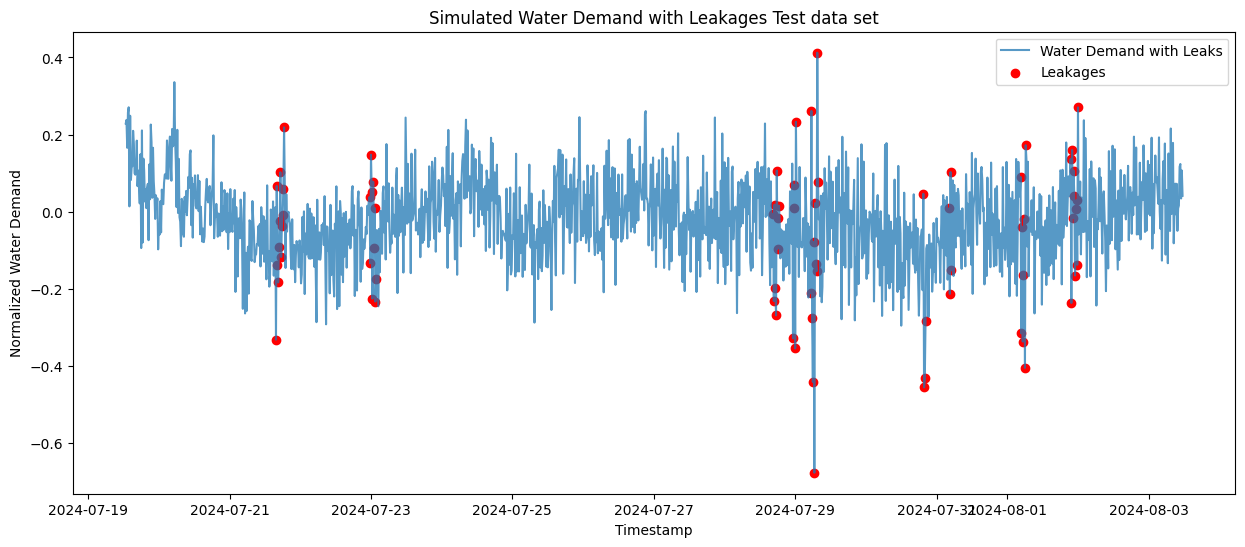

In [56]:

# Plotting the generated data
plt.figure(figsize=(15, 6))
plt.plot(dftest['Timestamp'], dftest['WaterDemandWithLeaks'], label='Water Demand with Leaks', alpha=0.75)
plt.scatter(dftest[dftest['LeakageLabel'] == 1]['Timestamp'], dftest[dftest['LeakageLabel'] == 1]['WaterDemandWithLeaks'], color='red', label='Leakages')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Normalized Water Demand')
plt.title('Simulated Water Demand with Leakages Test data set')
plt.show()

# Save to Excel